# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I = \varepsilon \int_{M_0}^{M_f} \mathbf{G}(I,M) \, u \ \textrm{d} M, \quad u \in \mathcal{U}$$
$$ \delta I (M_0) = 0, \quad \delta I (M_f) \parallel \mathbf{b}, $$
$$ \left( \delta I (M_f) \, | \, \mathbf{b} \right) \longrightarrow \max, $$
$$ M_0 = 0; M_f = 2 \pi $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{b}$. 

[Thumbnail](figs/kepler-py.png)

## Initializations

In [1]:
import numpy as np
import scipy
from scipy.integrate import ode
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from nutopy import path
from scipy.linalg import null_space
from gve import *
from gvef import *
from os import system

# Parameters of the problem
cont         = 0.02558 #0.0245          # 0 for triangular cone, 1 for real drop 
mu           = 1.

# Definition of optical parameters 
rho          = 0.88         # Specular reflection coefficient
a            = 1. - rho    # Absorption coefficient
s            = 0.94        # Diffuse reflection coefficient 
eps_f        = 0.05        # Emissivity front coeff 0.05
eps_b        = 0.55        # Emissivity back coeff 0.55
Bf           = 0.79        # Front Lambertian coeff 0.79
Bb           = 0.55        # Back Lambertian coeff 0.55
eps          = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p        = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b            = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])


def deg2rad(x):
    y        = x * np.pi / 180.
    return y


# Initial guess of pI taken from Matlab Convex Programming

""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE
rho          = 0.6
I            = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.5])  
pI           = np.array([ - 0.1577,  -0.3003, -0.1011,  -0.2680, 1.0000])
d            = np.array([ 0.,  0.,  0.,  0.,  1.]) 
#"""

# RESEARCH OF THE CHANGE OF STRUCTURE


""" for the u2 ? 
rho          = 0.95
I            = np.array([deg2rad(40), deg2rad(40), deg2rad(30), 1, 0.7]) 
pI           = np.array([ -0.9424,    1.0000,    0.0702,    0.1572,    0.1323])
d            = np.array([ 0.,  1.,  0.,  0.,  0.]) 
"""

""" 3 bangs
rho          = 0.95
I            = np.array([deg2rad(60), deg2rad(40), deg2rad(30), 1, 0.7]) 
pI           = np.array([  -1.4160,   -3.4709,   -0.7293,   -1.0000, 3.8980])
d            = np.array([ 0.,  0.,  0.,  -1.,  0.]) 
"""


#""" 
rho          = 0.88
I            = np.array([deg2rad(10), deg2rad(50), deg2rad(30), 1, 0.1]) 
pI           = np.array([ -0.0837,    1.0000,   -0.0052,    0.0398,    0.0852 ])
d            = np.array([ 0.,  1.,  0.,  0.,  0.]) 
#"""

""" 
rho          = 0.88
I            = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.5]) 
pI           = np.array([ -0.0837,    1.0000,   -0.0052,    0.0398,    0.0852 ])
d            = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""


# Initial guess for the shooting
z_auto       = np.hstack((pI))
sDir         = np.array([0., 0., -1.])


# Real cone force definition
cBeta        = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
               np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
               (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	     = np.sqrt(1 - cBeta ** 2);
fs           = b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp        = (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone        = np.array([fs, fperp])

pars         = np.hstack((mu, I, fCone, b))

# Orthogonal vector family
d_orth       = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth       = d_orth.transpose()

In [2]:
#!pygmentize hfun.f90		

## Hamiltonian

In [3]:
!python -m numpy.f2py -c hfun.f90     hfun.pyf     -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90   hfun_d.pyf   -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 hfun_d_d.pyf -m hfun_d_d > /dev/null 2>&1

In [4]:
from hfun     import hfun     
from hfun_d   import hfun_d   
from hfun_d_d import hfun_d_d 

hfun_u      = lambda M, q, p, pars, cont                                           : hfun.hfun_u(M, q, p, pars, cont)
control     = lambda M, q, p, pars, cont                                           : hfun.control(M, q, p, pars, cont) 
dhfun_u     = lambda M, dM, q, dq, p, dp, pars, cont, dcont                        : hfun_d.hfun_u_d(M, dM, q, dq, p, dp, pars, cont, dcont)
d2hfun_u    = lambda M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont : hfun_d_d.hfun_u_d_d(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont)

In [5]:
def dhfun_0(M, dM, q, dq, p, dp, pars, cont, dcont):
    h = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, q, p, pars, cont):
    h = 0.0
    return h

In [6]:
hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(1, 2, 3, 5), full=True)(hfun_u)
hfun_0      = tools.tensorize(dhfun_0, d2hfun_0, tvars=(1, 2, 3, 5), full=True)(hfun_0)
control     = tools.vectorize(vvars=(1,2,3))(control)
Hu          = ocp.Hamiltonian(hfun_u)
H0          = ocp.Hamiltonian(hfun_0)
fu          = ocp.Flow(Hu)
f0          = ocp.Flow(H0)

## Shooting function

In [7]:
def shoot_auto(z, pars, d, d_orth, cont):
    I0          = np.zeros(5)
    M0          = 0.
    Mf          = 2. * np.pi 
    pI          = z[0 : 5]
    I           = pars[1 : 6]
    
    #--------------------------------------------------------------------------
    # Integration of the trajectory 
    If, pIf     = fu(M0, I0, pI, Mf, pars, cont)

    #--------------------------------------------------------------------------
    # Shooting function    
    s        = np.zeros(5) # 5 conditions : orthogonality + parallelity
    
    s[0]     = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5] = np.dot(d_orth, If)
    
    # constant pI
    
    
             
    return s

# Solve

## Simple problem (no structure change)

In [8]:
#dfoo_auto = lambda z, dz, cont: shoot_auto((z, dz), pars, d, d_orth, (cont, 0.)) 
foo_auto  = lambda z, cont: shoot_auto(z, pars, d, d_orth, cont)

In [9]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
et = time.time(); sol_auto = nle.solve(foo_auto, z_auto, options=nleopt, args=cont); 
et = time.time() - et

print('Elapsed time:', et)
z_sol_auto = sol_auto.x; 

print('\n\n\n\n')
print('z_sol_auto               =', z_sol_auto)
print('foo_auto                 =', foo_auto(z_sol_auto, cont))
print('Initial guess            =', z_auto)
print('foo Initial guess (sail) =', foo_auto(z_auto, 1.))
print('foo Initial guess (cone) =', foo_auto(z_auto, 0.))




     Calls  |f(x)|                 |x|
 
         1  7.542836330923751e-01  1.007906647462948e+00
         2  1.041089467405747e+00  1.124506821363058e+00
         3  5.572324882858076e-01  1.021396917566620e+00
         4  2.060251357018179e-01  1.015901825220889e+00
         5  1.822123775754102e-02  1.015011207637031e+00
         6  5.539951998271045e-03  1.015236110344977e+00
         7  9.598335493526565e-03  1.015208642727278e+00
         8  9.916924717803952e-03  1.015196573247557e+00
         9  2.241728993871880e-03  1.015280643713983e+00
        10  1.921941012385584e-03  1.015159073683536e+00
        11  1.392221500632374e-03  1.014898760154295e+00
        12  3.440057434146996e-04  1.014380019738733e+00
        13  2.207840233402854e-05  1.014214228444285e+00
        14  3.863429956445436e-07  1.014215815174822e+00
        15  5.239585162328682e-08  1.014215873172910e+00
        16  1.129512141493602e-08  1.014215872105188e+00
        17  2.102855374919692e-09  1.014215871

# Post processing

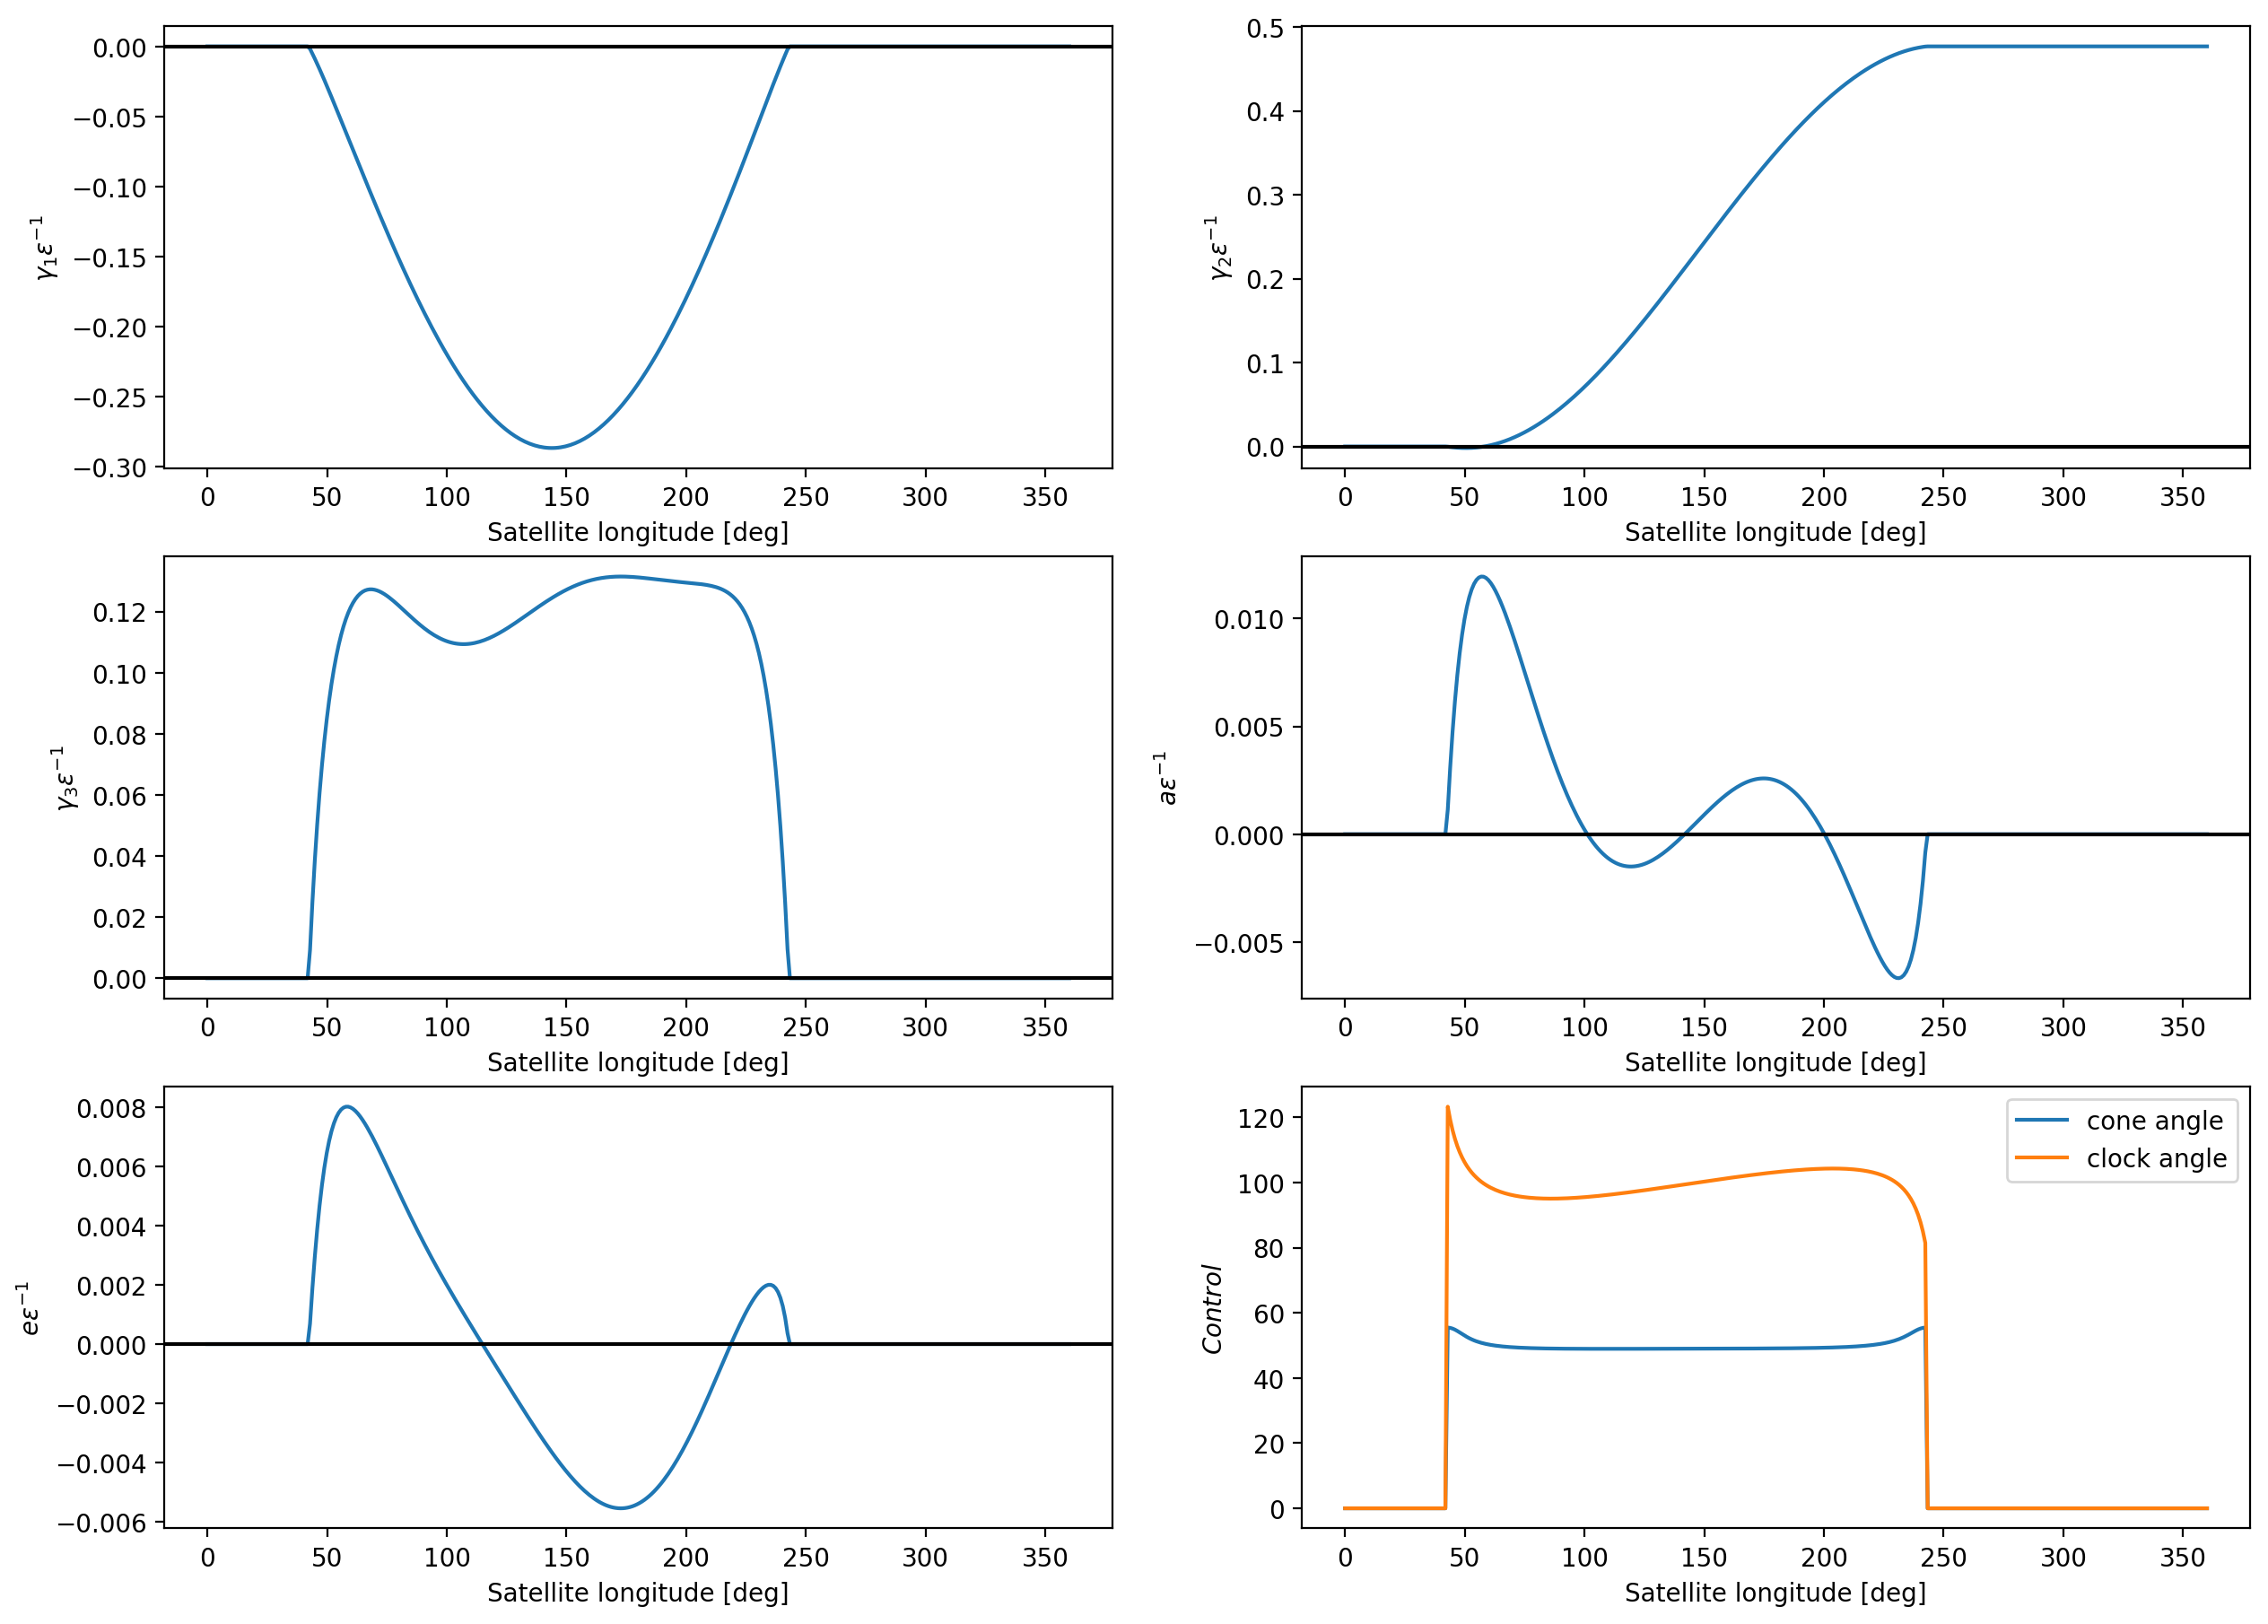

In [12]:
# Inputs
Ndis         = 360 + 1
#dpI0  = np.array([-0.0837,    1,   -0.0052,    0.0398,    0.0852])
dpI0         = z_sol_auto[0 : 5]

# Integration of the trajectory
M            = list(np.linspace(0., 2. * np.pi, Ndis + 1))
dI0          = np.zeros(5)

dI, dpI      = fu(0., dI0, dpI0, M, pars, cont)

g1           = np.zeros(Ndis + 1)
g2           = np.zeros(Ndis + 1)
g3           = np.zeros(Ndis + 1)
a            = np.zeros(Ndis + 1)
e            = np.zeros(Ndis + 1)
u            = np.zeros((Ndis + 1, 3))

for kk in range(Ndis + 1):
    g1[kk]   = dI[kk][0]
    g2[kk]   = dI[kk][1]
    g3[kk]   = dI[kk][2]
    a[kk]    = dI[kk][3]
    e[kk]    = dI[kk][4]
    u[kk]    = control(M[kk], dI[kk], dpI[kk], pars, cont)

# Components of the control vector
u_s          = np.dot(u,sDir)
u_1          = u[:,0]
u_2          = u[:,1]
u_3          = u[:,2]

np.seterr(divide='ignore', invalid='ignore')

uNorm        = np.linalg.norm(u, axis = 1)
uCone        = np.arccos(u_s / uNorm)
coast        = np.isnan(uCone)
uCone[coast] = 0.
uClock       = np.arctan2(u[:, 1] / uNorm , u[:, 0] / uNorm)
coast        = np.isnan(uClock)
uClock[coast]= 0.

# verification u / || u || = (sin beta cos delta, sin beta sin delta, cos beta)
#uClock       = np.arcsin(np.sqrt((u_1 / np.linalg.norm(u, axis = 1)) ** 2  + (u_2 / np.linalg.norm(u, axis = 1)) ** 2))



#file1 = open("results/Results_simple_shoot_change_structure.txt","w+")
#array_proj = np.transpose(np.array([M,u_1,u_2,u_3]))
#np.savetxt(file1, array_proj , delimiter=",")
#file1.close()

#file2 = open("results/Traj_simple_shoot_change_structure.txt","w+")
##file2 = open("results/Traj_convex_2.txt","w+")
#array_traj = np.transpose(np.array([M,g1,g2,g3,a,e]))
#np.savetxt(file2, array_traj , delimiter=",")
#file2.close()


Mdeg         = [Mi * 180. / np.pi for Mi in M] 
    
# Plot

fig          = plt.figure(); plt.tight_layout()
ax1          = fig.add_subplot(421) 
ax2          = fig.add_subplot(422) 
ax3          = fig.add_subplot(423) 
ax4          = fig.add_subplot(424) 
ax5          = fig.add_subplot(425) 
ax6          = fig.add_subplot(426) 

ax1.plot(Mdeg, g1)
ax2.plot(Mdeg, g2) 
ax3.plot(Mdeg, g3) 
ax4.plot(Mdeg, a) 
ax5.plot(Mdeg, e)
ax6.plot(Mdeg, uCone * 180. / np.pi, label='cone angle')
ax6.plot(Mdeg, uClock * 180. / np.pi, label='clock angle') 

#ax6.plot(Mdeg, -u_3, label='$u_1$'); 
#ax6.plot(Mdeg, u_1, label='$u_2$');
#ax6.plot(Mdeg, -u_2, label='$u_3$');

xlabel       = 'Satellite longitude [deg]'
ax1.set_xlabel(xlabel); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
ax2.set_xlabel(xlabel); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
ax3.set_xlabel(xlabel); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
ax4.set_xlabel(xlabel); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
ax5.set_xlabel(xlabel); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
#ax6.set_xlabel(xlabel); ax6.set_ylabel('$Control \ angle $'); 
ax6.set_xlabel(xlabel); ax6.set_ylabel('$Control$'); 
ax6.legend()
plt.savefig('figures/plot.png')


# Integration of the trajectory for the real system with the control

In [21]:
def dynamics(t, x, z_sol, pars, cont):
    Csrp       = 1e-8
    dpI0       = z_sol[0 : 5]
    dI0        = np.zeros(5)
    dI, dpI    = fu(0., dI0, dpI0, x[5], pars, cont)
    u          = Csrp * control(x[5], dI, dpI, pars, cont)
    mu         = pars[0]	
    [Fx,Fy,Fz] = gveeci(x, mu)
    dx         = np.dot(np.transpose(np.array([Fx,Fy,Fz])), u)
    n          = np.sqrt(mu/(x[3]**3))
    dx[-1]     = dx[-1] + n
    return dx
    



dyn_fun       = lambda t, x        : dynamics(t, x, z_sol_auto, pars, cont)




In [12]:
x0, t0 = np.hstack((I,0)), 0
Nsteps = 360
tf     = 2*np.pi
sol    = scipy.integrate.RK45(dyn_fun, t0, x0, t_bound = tf, max_step = tf/Nsteps, rtol=0.001, atol=1e-06)

t_values = []
g1_values = []
g2_values = []
g3_values = []
a_values = []
e_values = []
for i in range(500):
    # get solution step state
    sol.step()
    t_values.append(sol.t)
    g1_values.append(sol.y[0])
    g2_values.append(sol.y[1])
    g3_values.append(sol.y[2])
    a_values.append(sol.y[3])
    e_values.append(sol.y[4])
    # break loop after modeling is finished
    if sol.status == 'finished':
        break
    

In [13]:

#file2 = open("results/Traj_real_simple_shoot_change_structure.txt","w+")
##file2 = open("results/Traj_convex_2.txt","w+")
#array_traj = np.transpose(np.array([t_values,g1_values,g2_values,g3_values,a_values,e_values]))
#np.savetxt(file2, array_traj , delimiter=",")
#file2.close()


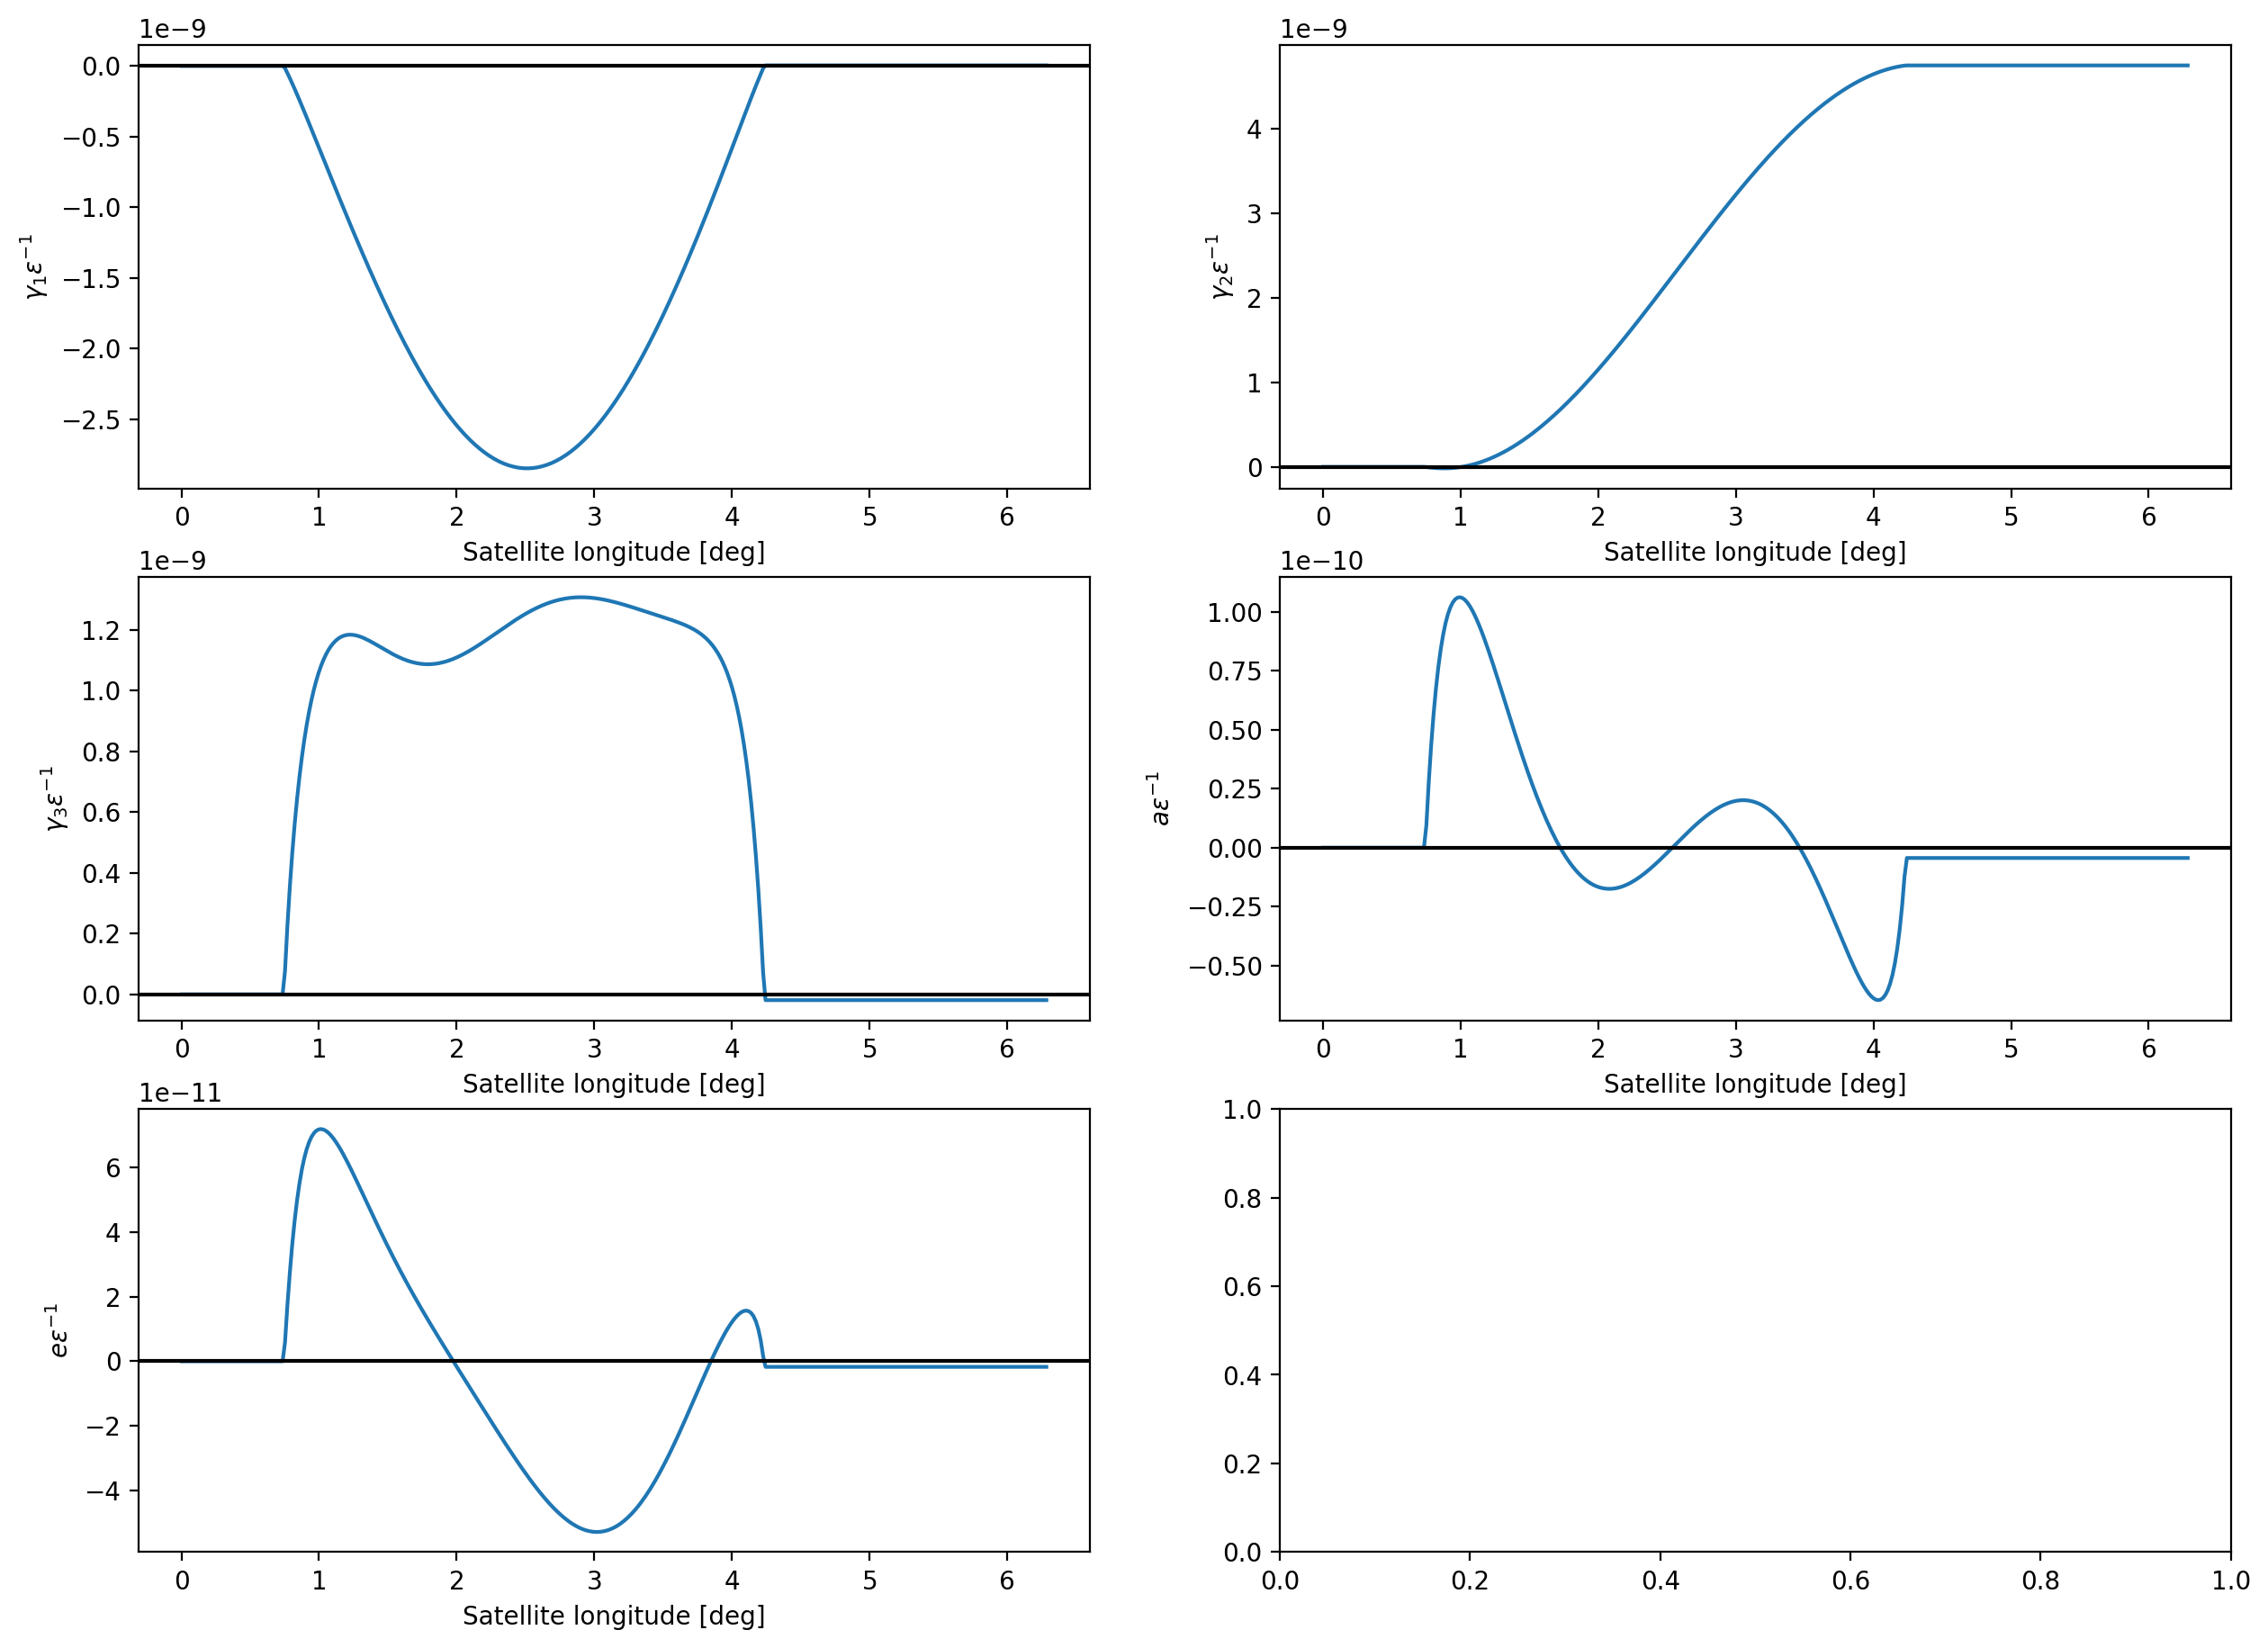

In [14]:
fig          = plt.figure(); plt.tight_layout()
ax1          = fig.add_subplot(421) 
ax2          = fig.add_subplot(422) 
ax3          = fig.add_subplot(423) 
ax4          = fig.add_subplot(424) 
ax5          = fig.add_subplot(425) 
ax6          = fig.add_subplot(426) 

ax1.plot(t_values, g1_values-I[0])
ax2.plot(t_values, g2_values-I[1])
ax3.plot(t_values, g3_values-I[2])
ax4.plot(t_values, a_values-I[3])
ax5.plot(t_values, e_values-I[4])
#ax6.plot(time[:-1], out[:,5])

xlabel       = 'Satellite longitude [deg]'
ax1.set_xlabel(xlabel); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
ax2.set_xlabel(xlabel); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
ax3.set_xlabel(xlabel); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
ax4.set_xlabel(xlabel); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
ax5.set_xlabel(xlabel); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')

# Classical Orbital Elements TO RV

In [15]:
def coe2rv(oe, mu):
    a = oe[0]; e = oe[1]; i = oe[2]; Omega = oe[3]; omega = oe[4]; theta = oe[5]
    r      = a * (1 - e **2) / (1 + e * np.cos(theta))
    h      = np.sqrt(mu * a * (1 - e ** 2))
    sOmega = np.sin(Omega); cOmega = np.cos(Omega); somega = np.sin(omega); comega = np.cos(omega); si = np.sin(i); ci = np.cos(i)
    IP     = np.array([[cOmega * comega - sOmega * ci * somega, - cOmega * somega - sOmega * ci * comega, sOmega * si], \
                      [sOmega * comega + cOmega * ci * somega, - sOmega * somega + cOmega * ci * comega, - cOmega * si], \
                      [si * somega,                            si * comega,                              ci]])
    vect   = np.array([r * np.cos(theta), r * np.sin(theta), 0, - mu/h * np.sin(theta), mu/h * (np.cos(theta) + e), 0])
    r_vect = np.dot(IP, vect[0:3])
    v_vect = np.dot(IP, vect[3:6])
    #s      = np.hstack((r_vect, v_vect))
    return r_vect, v_vect

In [16]:
np.size(t_values)

361

In [17]:
N_size      = np.size(t_values)
r_mat       = np.zeros([3,N_size])
v_mat       = np.zeros([3,N_size])

for i in range(N_size):
    f       = kepler(e_values[i], t_values[i])
    oe      = np.array([a_values[i], e_values[i], g2_values[i], g1_values[i], g3_values[i], f])
    r_mat[:,i], v_mat[:,i] = coe2rv(oe, mu)



(361,)
(3, 361)


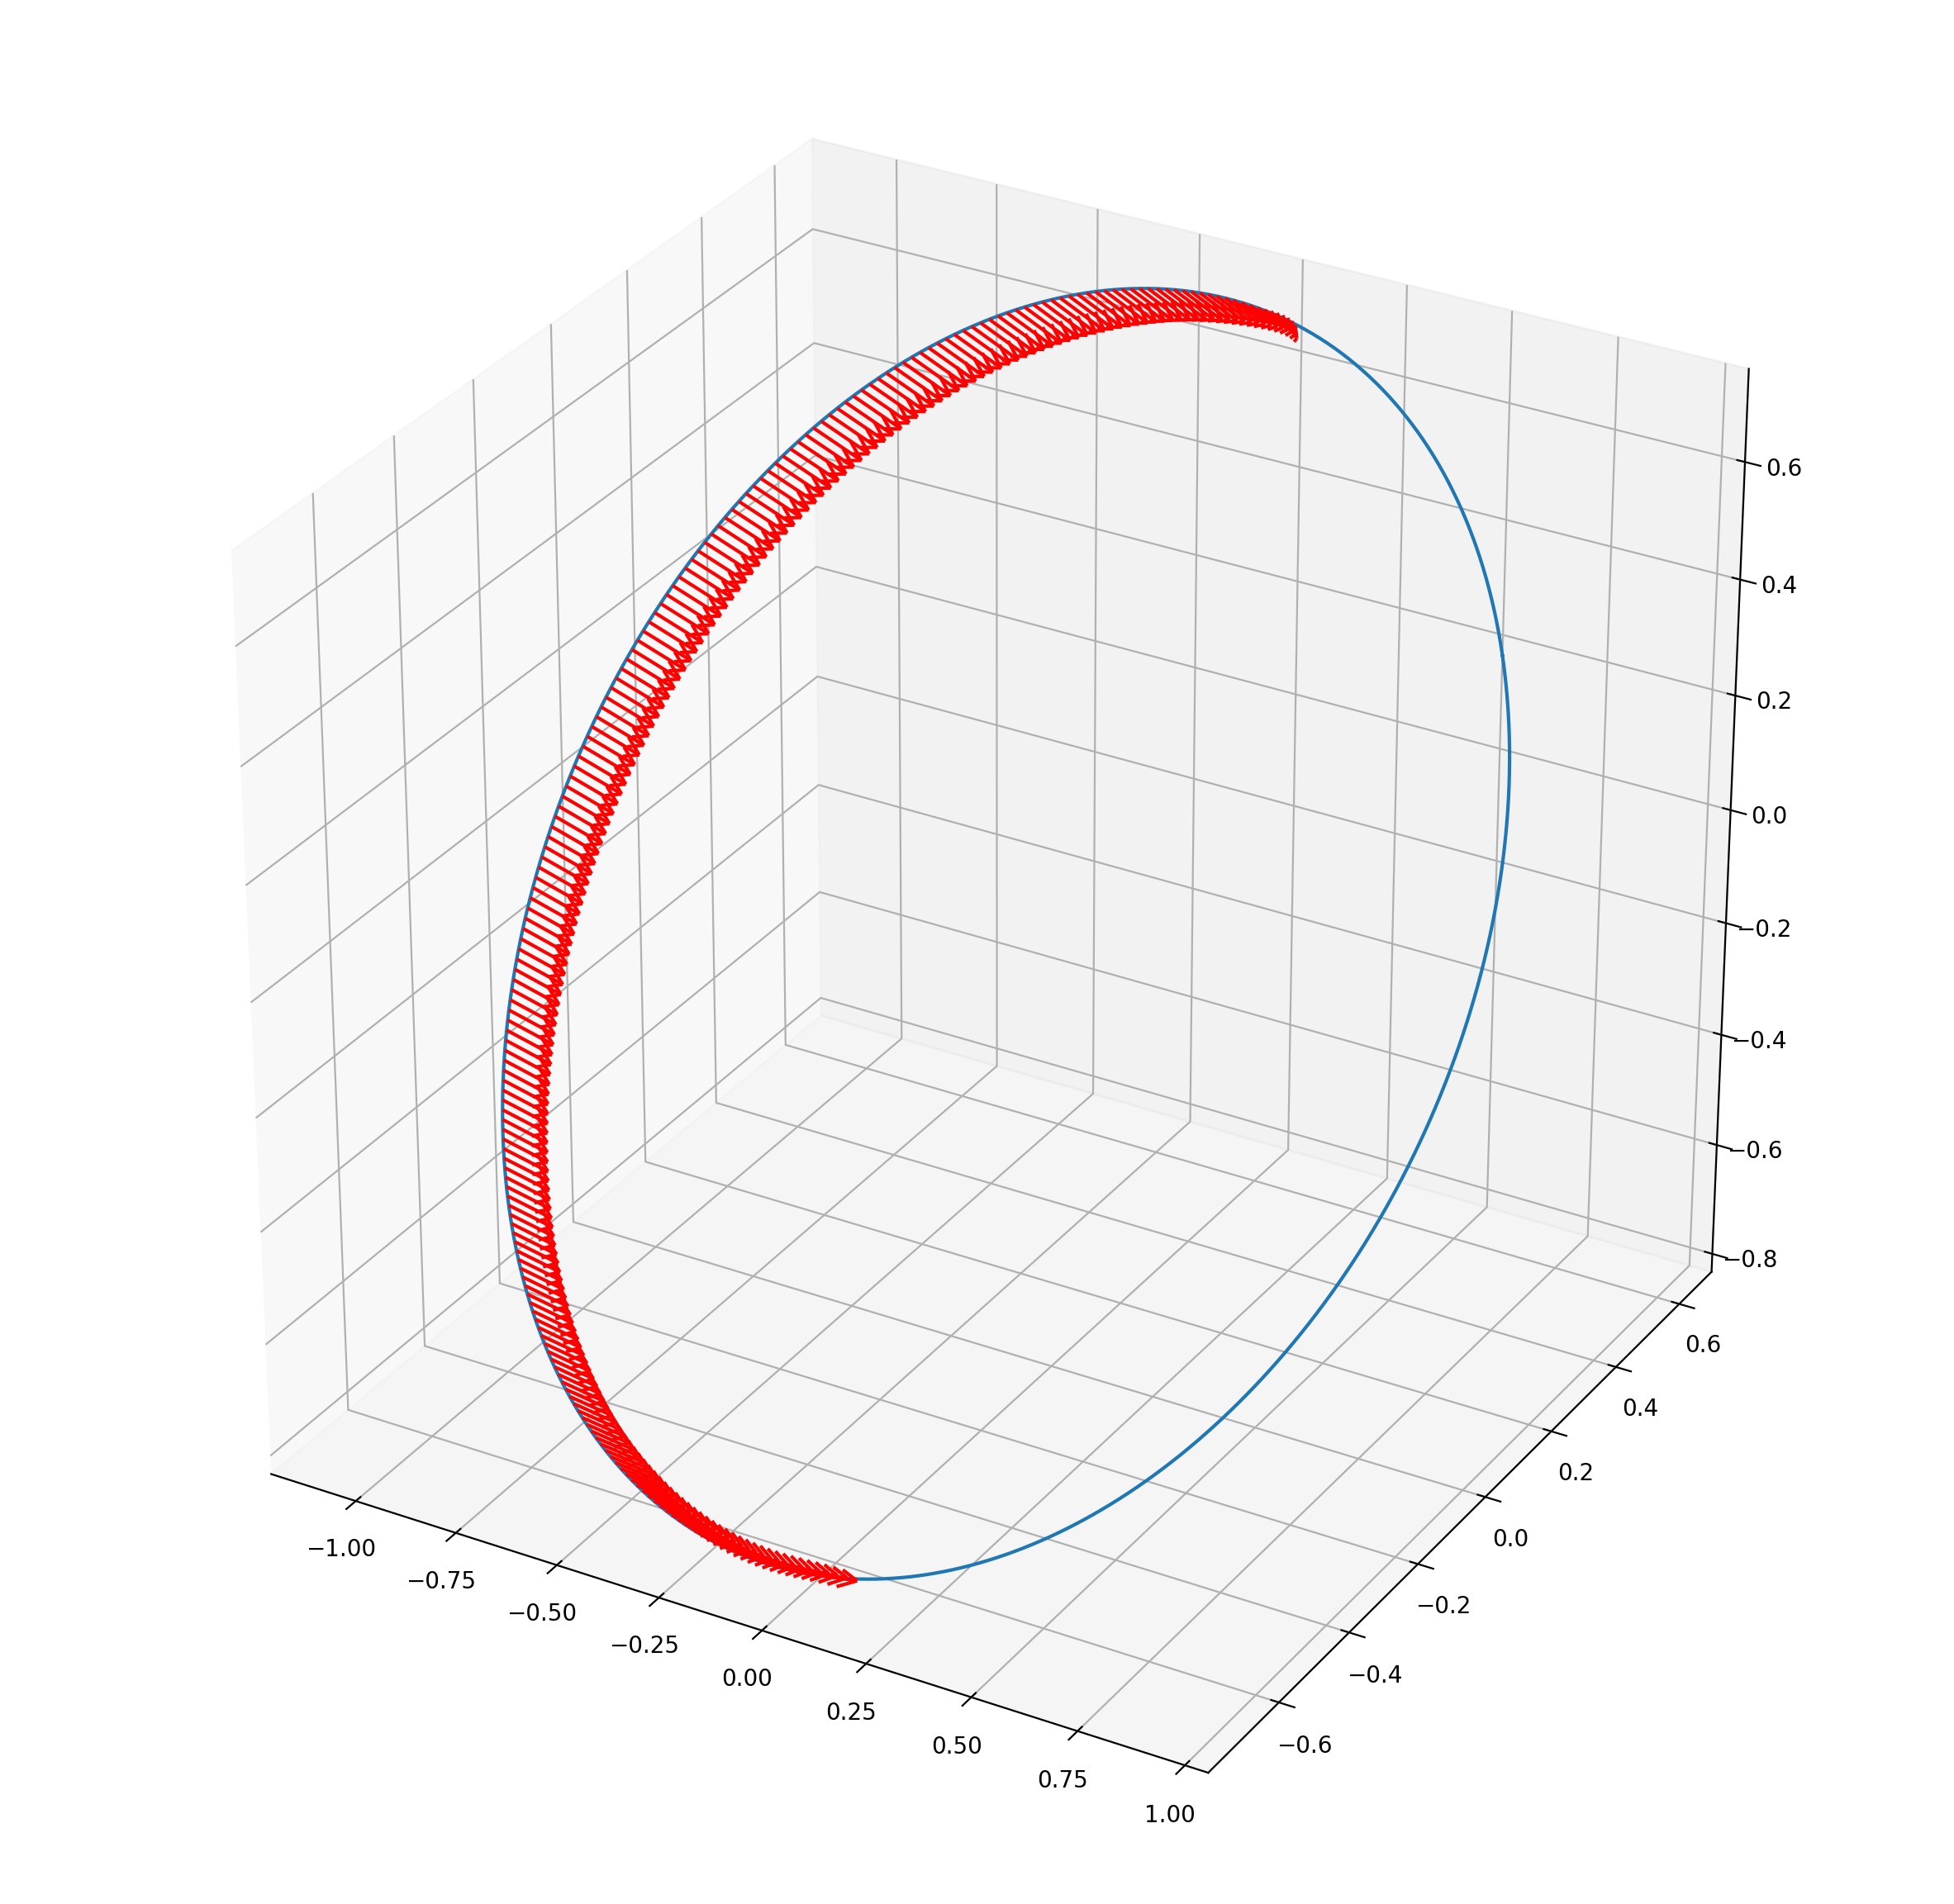

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(r_mat[0,:], r_mat[1,:], r_mat[2,:])
V = np.vstack((u_1[1:], u_2[1:], u_3[1:]))
#V = np.array([[1,1,0], [-2,2,0], [4,-7,0]])
print(np.shape(V[0,:]))
origin = r_mat # origin point
print(np.shape(origin))
plt.quiver(*origin, V[0,:], V[1,:], V[2,:], color=['r'])#, scale=21)

In [19]:

file2 = open("results/Vectors_control.txt","w+")
array_traj = np.transpose(np.array([r_mat[0,:], r_mat[1,:], r_mat[2,:], V[0,:], V[1,:], V[2,:]]))
np.savetxt(file2, array_traj , delimiter=",")
file2.close()

